<a href="https://colab.research.google.com/github/abdipourasl/OCD/blob/main/MNE_Preprocessing_%26_Connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import tensorflow as tf
import os
import cv2
import imghdr
from google.colab import drive
%matplotlib inline
import os
import os.path as op
!pip install mne
import mne
import numpy as np
import pandas as pd
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')
data_dir= '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div class="alert alert-block alert-success">
<h1>EEG Preprocessing with MNE</h1>
</div>

### 1. Importing Raw  Data

In [33]:
examples_dir = os.path.join('/content/drive/My Drive/','OCD_subj46.EDF')  # Path to the raw EEG Data folder
raw = mne.io.read_raw_edf(os.path.join('/content/drive/My Drive/','OCD_subj46.EDF'))                                                         # Loading continuous data
print(raw)

Extracting EDF parameters from /content/drive/My Drive/OCD_subj46.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<RawEDF | OCD_subj46.EDF, 23 x 165500 (331.0 s), ~27 kB, data not loaded>


In [34]:
raw.crop(tmin=5., tmax=50.)

<RawEDF | OCD_subj46.EDF, 23 x 22501 (45.0 s), ~27 kB, data not loaded>

### 2. Downsampling

In [35]:
raw.resample(250, npad="auto")    # set sampling frequency to 256 points per second

<RawEDF | OCD_subj46.EDF, 23 x 11250 (45.0 s), ~2.0 MB, data loaded>

### 3. Channel Selection

In [36]:
raw.pick_channels(['Fp1','Fp2','F7','F3','F4','F8','T3','C3','C4','T4','T5','P3','P4','T6','O1','O2','Fz','Cz','Pz'],ordered=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | OCD_subj46.EDF, 19 x 11250 (45.0 s), ~1.7 MB, data loaded>

In [37]:
print(raw.info["ch_names"])
print(raw)

['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'C4', 'T4', 'T5', 'P3', 'P4', 'T6', 'O1', 'O2', 'Fz', 'Cz', 'Pz']
<RawEDF | OCD_subj46.EDF, 19 x 11250 (45.0 s), ~1.7 MB, data loaded>


>according to the Nyquist frequency, sampling rate should be at least two times of frequency.
Moreover, 128 points are suitable and 256 points are desirable


### 4. Rereference

In [38]:
raw.set_eeg_reference('average', projection=True).apply_proj()  # re-referencing with the virtual average reference

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawEDF | OCD_subj46.EDF, 19 x 11250 (45.0 s), ~1.7 MB, data loaded>

### 5. Clean Data - ASR



In [39]:
raw_uncleaned = raw.copy()

First of all, we initialize an instance of the `ASR` class, which stores predefined parameters (like the rejection threshold), the functional procedures as well as the parameters matrices that are used to transform data.

If you are familiar with [scikit-learn](https://scikit-learn.org/stable/), you will notice that a lot of MNE's automated cleaning and decoding functions work similar to scikit learn and can usually be seamlessly integrated into sklearn pipelines (which is due to the fact that some of the MNE developers also work on sklearn). This is especially helpful for brain decoding and BCI applications.

At initialization our ASR instance needs to know the sampling frequency of our raw data (which is required for multiple features of the algorithms). We also tell it to repair portions of data whose variance is 5 standard deviations larger than the reference data.

#### 5.1. Auto Reject

#### 5.2 ASR - Cleaning / Still Error :)

In [40]:
!pip install asrpy -q
from asrpy import ASR
asr = ASR(sfreq=raw.info["sfreq"], cutoff=5)

Now we fit our asr object to the data.

We will use our entire raw data to fit. If your dataset is too large, you could also just use a fraction of the data for fitting. Theoretically, you could fit your cleaning algorithm to one dataset and then apply it to another, but this is very unusual and only makes sense for very specific experimental setups.

In [41]:
asr.fit(raw)

After our `asr` object was fitted to a certain dataset, we can apply it to our recorded raw data. The uncleaned data is transformed (/interpolated) according to the ASR procedure.

In [42]:
raw._data = asr.transform(raw)

Uncleaned data


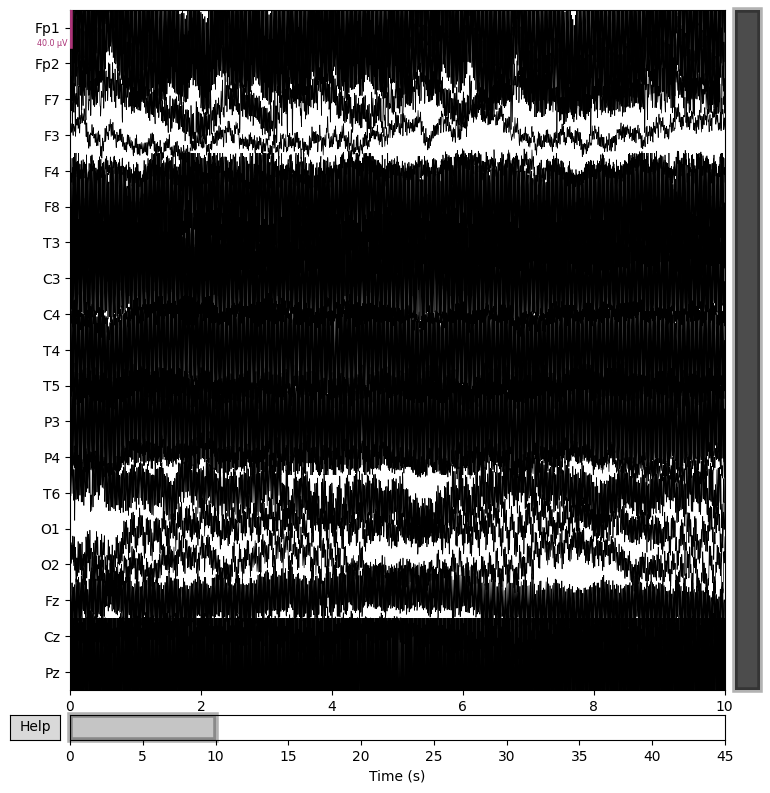

Cleaned data


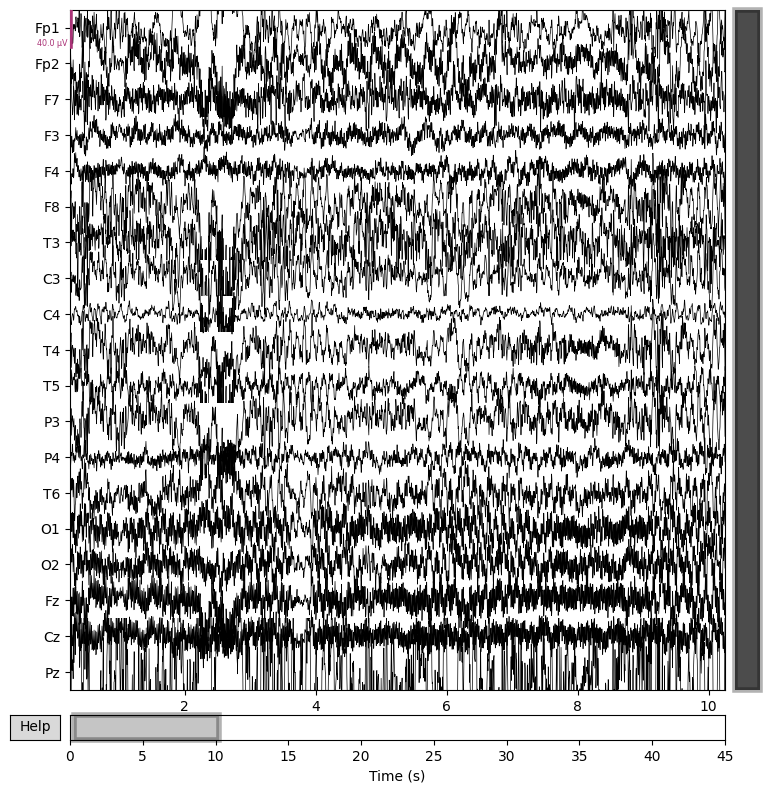

In [43]:
scalings= {"eeg":2e-5}

print("Uncleaned data")
raw_uncleaned.plot(scalings=scalings);

print("Cleaned data")
raw._data.plot(start=0.25, scalings=scalings);

### 6. Filtering the data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
<ipython-input-44-c6ea746ce700>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw._data.plot_psd(fmax=100);


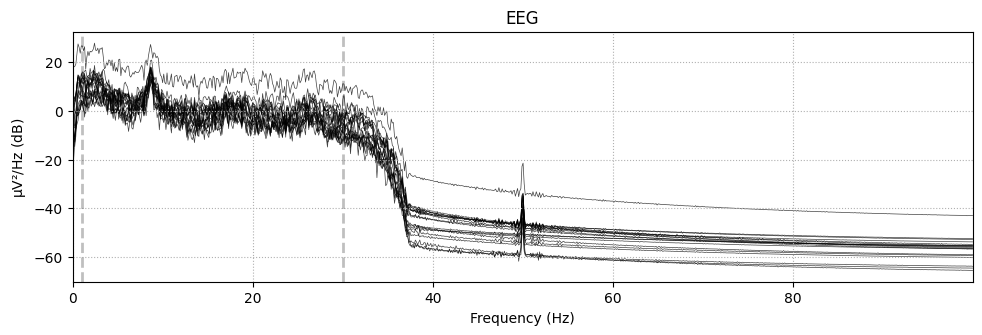

In [44]:
raw._data.filter(1, 30, fir_design='firwin', picks=['eeg'])  # band-pass filter from 1 to 30 frequency over just
                                                       # EEG channel and not EEG channel
raw._data.plot_psd(fmax=100);

>Lw-pass filter with 1 Hz cutoff frequency for removing low-frequency drifts.
    High-pass filter with 30 Hz cutoff frequency for deteriorating the effect of
    the AC power line frequency, cell phones, the geomagnetic field and so forth.
    Therefore, a band-pass filter was used in the range 1Hz-30Hz with one step.
    You can apply another band pass filter due to your own assumtions and hypotheses.
    I recommend that band pass filtering would be better to occurr before the EEG
    data epoching and artifact removal with ICA.

In [45]:
raw._data.notch_filter(freqs=[16.667, 50]); # bandstop the train and power grid

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


<ipython-input-46-87859e86b114>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw._data.plot_psd(fmax=100);


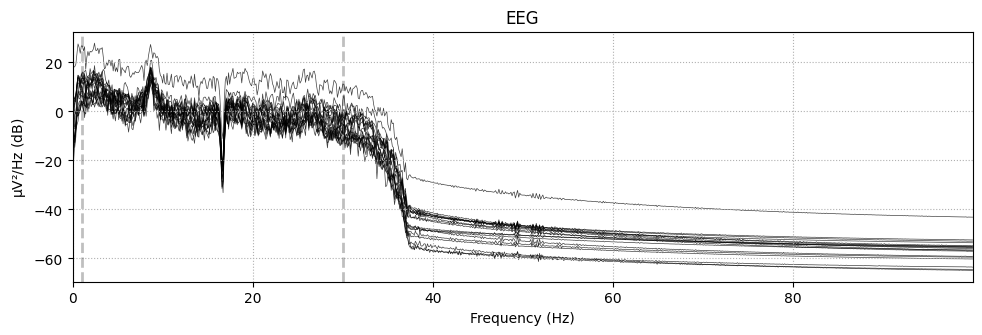

In [46]:
raw._data.plot_psd(fmax=100);

### 7. Visual Inspection

###### 7.1 Plot continuous data

In [47]:
#%matplotlib qt
#raw.plot()       # plot the EEG data. Use the '%matplotlib qt' to see
                 # the data in a bright way and move conveniently

>Use of visual inspection to reject some segments which have abnormal frequency,
     signal discontinuous, abrupt jumping, irrelevant-task and son on.
     Trace all EEG channels during time.
     The best way to remove segtion of the data is deleting annotations in the segtion.
     In addition, when you see irrelavant task or noise segemt in specefict channel,
     you shoud remove the sement in all channels
     Afterward, The instances of noisy segment which should be removed are created by
     providing a EXCELL file with two columns of onsets and  offsets with descriptions
     for each segment. The onsets and offsets are marked as seconds. onset refers to time
     from start of the data. offset refers to time from end of the data

###### 7.2 channel bad correction

### 8. Segmenting continuous data into epochs (2s with 0.5 Overlap)

In [48]:
epochs = mne.make_fixed_length_epochs(raw._data, duration=2.0, preload=False, reject_by_annotation=False, proj=False, overlap=1, id=1, verbose=None)

Not setting metadata
44 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


Using data from preloaded Raw for 44 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
44 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


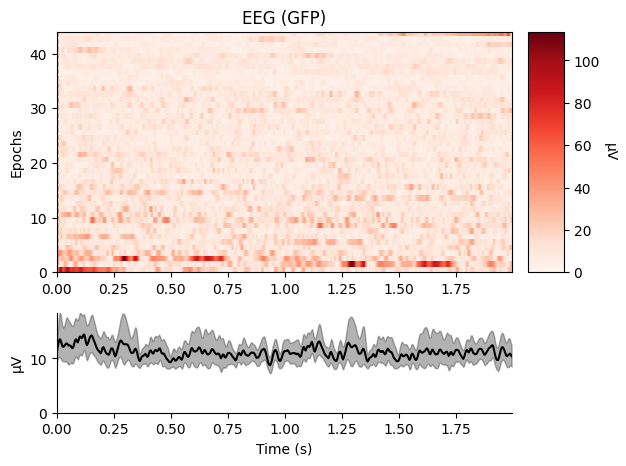

In [49]:
event_related_plot = epochs.plot_image()


### 9. Connectivity



In [50]:
epochs.get_data()

Using data from preloaded Raw for 44 events and 500 original time points ...


array([[[-3.68069251e-21, -3.03536035e-05, -5.29023569e-05, ...,
         -2.06291007e-05, -2.25269340e-05, -2.31876408e-05],
        [ 9.87183465e-21,  2.57186067e-05,  4.46506778e-05, ...,
          8.83011943e-06,  7.96438478e-06,  7.06063459e-06],
        [ 8.17776875e-21,  2.49524306e-05,  4.33311737e-05, ...,
          9.61841589e-07,  2.70525267e-06,  3.31563934e-06],
        ...,
        [ 9.44831817e-21,  1.27158182e-05,  2.20483393e-05, ...,
          1.20283409e-05,  9.81872446e-06,  6.86320374e-06],
        [ 5.54472225e-22,  9.67311576e-07,  1.65119532e-06, ...,
          7.70564440e-06,  4.12033176e-06,  4.43545781e-07],
        [-1.46921208e-20, -1.77515173e-04, -3.08993409e-04, ...,
         -9.55254333e-05, -1.01090810e-04, -1.01264038e-04]],

       [[ 1.95959660e-05,  1.04335733e-05, -3.07784028e-07, ...,
         -2.23730996e-05, -2.65450676e-05, -3.09691818e-05],
        [-9.43670428e-06, -6.98779038e-06, -4.56850781e-06, ...,
          7.13354687e-06,  1.07496950e

In [51]:
!pip install -U mne-connectivity
import mne_connectivity


In [52]:
#from mne_connectivity import envelope_correlation
corr_matrix = mne_connectivity.envelope_correlation(epochs.get_data()).get_data()
print(corr_matrix.shape)
print(epochs.get_data().shape)

Using data from preloaded Raw for 44 events and 500 original time points ...
(44, 19, 19, 1)
Using data from preloaded Raw for 44 events and 500 original time points ...
(44, 19, 500)


In [63]:
alpha_plv=mne_connectivity.spectral_connectivity_time(epochs.get_data(), freqs=(8., 12.), method='plv', average=False, indices=None, sfreq=raw.info["sfreq"], fmin=None, fmax=None, fskip=0, faverage=False, sm_times=0, sm_freqs=1)
print(alpha_plv.shape)
type(alpha_plv.shape)


Using data from preloaded Raw for 44 events and 500 original time points ...
Fmin was not specified. Using fmin=min(freqs)
Fmax was not specified. Using fmax=max(freqs).
Connectivity computation...
   Processing epoch 1 / 44 ...
   Processing epoch 2 / 44 ...
   Processing epoch 3 / 44 ...
   Processing epoch 4 / 44 ...
   Processing epoch 5 / 44 ...
   Processing epoch 6 / 44 ...
   Processing epoch 7 / 44 ...
   Processing epoch 8 / 44 ...
   Processing epoch 9 / 44 ...
   Processing epoch 10 / 44 ...
   Processing epoch 11 / 44 ...
   Processing epoch 12 / 44 ...
   Processing epoch 13 / 44 ...
   Processing epoch 14 / 44 ...
   Processing epoch 15 / 44 ...
   Processing epoch 16 / 44 ...
   Processing epoch 17 / 44 ...
   Processing epoch 18 / 44 ...
   Processing epoch 19 / 44 ...
   Processing epoch 20 / 44 ...
   Processing epoch 21 / 44 ...
   Processing epoch 22 / 44 ...
   Processing epoch 23 / 44 ...
   Processing epoch 24 / 44 ...
   Processing epoch 25 / 44 ...
   Processi

tuple

In [66]:
alpha_plv2 = np.asarray(alpha_plv)
print(alpha_plv2.shape)
type(alpha_plv2.shape)

()


tuple

In [67]:
alpha_plv = alpha_plv.mean(1)

TypeError: ignored

In [64]:
node_names = ['Fp1','Fp2','F7','F3','F4','F8','T3','C3','C4','T4','T5','P3','P4','T6','O1','O2','Fz','Cz','Pz']
mne_connectivity.viz.plot_connectivity_circle(alpha_plv, node_names, indices=None, n_lines=None, node_angles=None, node_width=None, node_height=1.0, node_colors=None, facecolor='black', textcolor='white', node_edgecolor='black', linewidth=1.5, colormap='hot', vmin=None, vmax=None, colorbar=True, title=None, colorbar_size=0.2, colorbar_pos=(-0.3, 0.1), fontsize_title=12, fontsize_names=8, fontsize_colorbar=8, padding=6.0, ax=None, fig=None, subplot=None, interactive=True, node_linewidth=2.0, show=True)

ValueError: ignored